In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [139]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [119]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [7]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [8]:
raw_data.shape

(325, 335)

In [13]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [16]:
labels["Risk"][labels["Risk"]=="HR"].value_counts()

HR    214
Name: Risk, dtype: int64

In [17]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [18]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
LR_typical = labels[LR & typical]

In [19]:
HR = labels["Risk"]=="HR"
HR_nontypical = labels[HR & ~typical]

In [20]:
analysis_labels = pd.concat((LR_typical, HR_nontypical))
analysis_labels["Risk"].value_counts()

LR    99
HR    65
Name: Risk, dtype: int64

In [21]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [23]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

print(train_data.shape)
train_labels.value_counts()

(131, 333)


1    79
0    52
dtype: int64

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

In [202]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 150, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.0))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.0))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    SGD=keras.optimizers.SGD(lr=0.001)
#     NSGD = keras.optimizers.SGD(lr=0.0001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [203]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3775      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 53,901
Trainable params: 53,901
Non-trainable params: 0
_________________________________________________________________


In [204]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time),
                          update_freq="epoch", write_graph=False)

In [205]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=100, batch_size=20, verbose=0, callbacks=[tensorboard])

CPU times: user 2.13 s, sys: 439 ms, total: 2.56 s
Wall time: 1.5 s


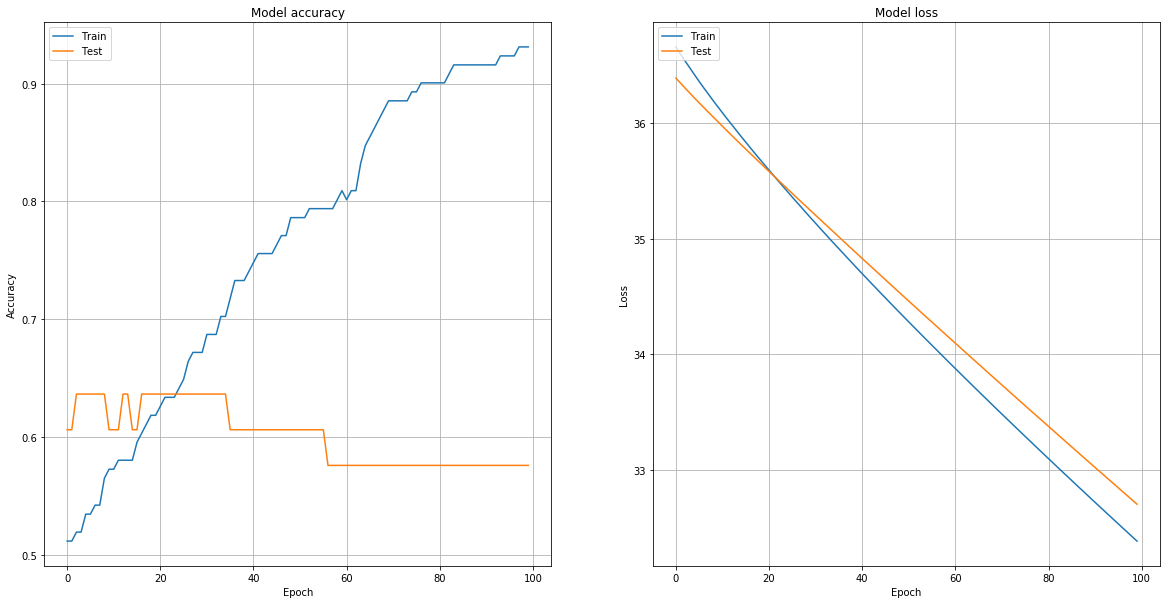

33/33 [==============================] - 0s 67us/step
Loss:32.702, Acc:0.5758


In [206]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.53846154 0.46153846]
 [0.4        0.6       ]]
Overall Accuracy: 0.5758


(<matplotlib.axes._subplots.AxesSubplot at 0x1a3ad845c0>, array([[ 7,  6],
        [ 8, 12]]))

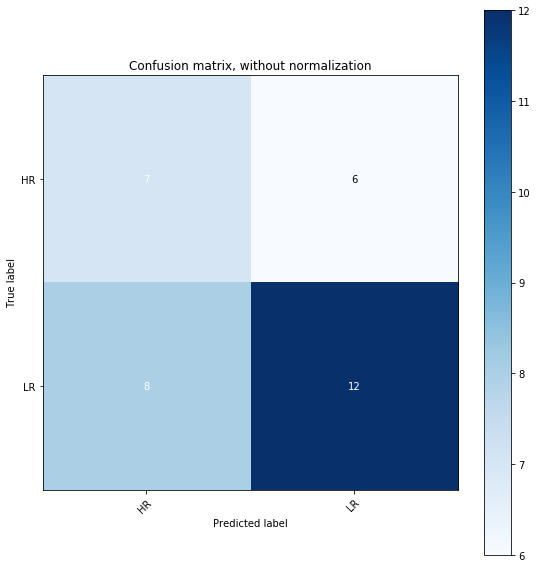

In [207]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [209]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.4666666666666667

## Calculate LRP

In [31]:
correct_HR_samples = X_valid[y_pred == np.ravel(y_valid) & (val_samples["Risk"]=="HR").values]

In [32]:
import innvestigate
import innvestigate.utils as iutils

analyzer_type = "lrp.epsilon"
analyzer_kwargs = {
    "pattern.attribution":
        {"pattern_type":"relu"},
    "lrp.epsilon":
        {"epsilon":1e-3}
 }

model_wo_softmax = dnn
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(dnn)

analyzer = innvestigate.create_analyzer(analyzer_type, model_wo_softmax,
                                        **analyzer_kwargs[analyzer_type])
analyzer.fit(X_train, batch_size=20, verbose=1, disable_no_training_warning=True)

In [33]:
lrp = analyzer.analyze(correct_HR_samples)
# pd.DataFrame(relevance_results)
lrp.shape

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


(6, 333)

In [34]:
def plot_3d_lrp(lrp):
    
    if lrp.shape[1] > 3:

        embedding_pipeline = Pipeline([
            ("reducer", umap.UMAP(random_state=42,
                            n_components = 3,
                            n_neighbors=160,
                            min_dist=0)),
           ("scaler", MinMaxScaler())
        ])
        embedding_pipeline.fit(lrp)
        embedding = embedding_pipeline.transform(lrp)
    else:
        embedding = lrp
            

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
#             color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8,
            showscale=True
        ),
#         text=pipeline.clusterer.labels_
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )

    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.

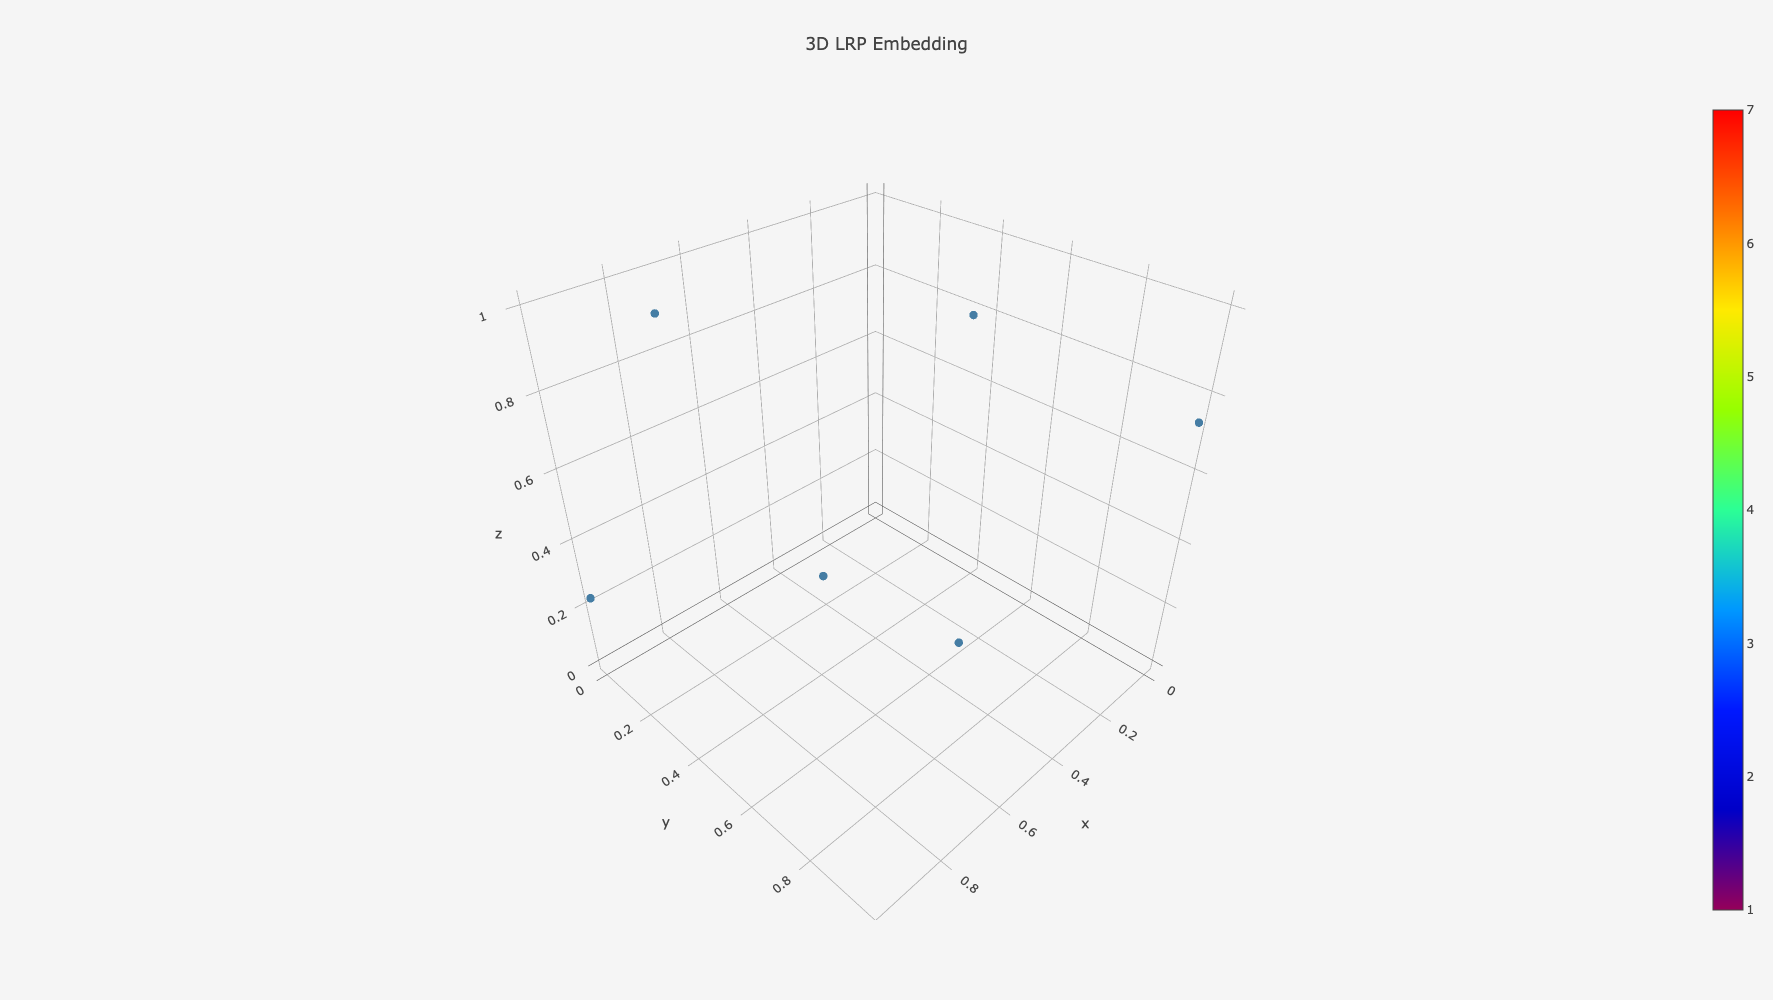

In [35]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=5,
                    min_dist=0)

reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
])

reducer_pipeline.fit(lrp)
embeddings = reducer_pipeline.transform(lrp)
plot_3d_lrp(lrp)

### Cross Validating

In [36]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.1)

In [37]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [38]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:30.991, Acc:0.9730
Prediction Accuracy
13/13 [==============================] - 0s 2ms/step
Scores on data set: loss=31.634 accuracy=0.5385
Fold Correct: 7
Running worker: 1
Fold: 1 -> Loss:31.007, Acc:0.9730
Prediction Accuracy
13/13 [==============================] - 0s 50us/step
Scores on data set: loss=31.089 accuracy=0.7692
Fold Correct: 10
Running worker: 2
Fold: 2 -> Loss:30.984, Acc:0.9910
Prediction Accuracy
13/13 [==============================] - 0s 40us/step
Scores on data set: loss=31.533 accuracy=0.6154
Fold Correct: 8
Running worker: 3
Fold: 3 -> Loss:30.996, Acc:0.9820
Prediction Accuracy
13/13 [==============================] - 0s 30us/step
Scores on data set: loss=31.436 accuracy=0.6154
Fold Correct: 8
Running worker: 4
Fold: 4 -> Loss:30.978, Acc:0.9910
Prediction Accuracy
13/13 [==============================] - 0s 42us/step
Scores on data set: loss=31.860 accuracy=0.5385
Fold Correct: 7
Running worker

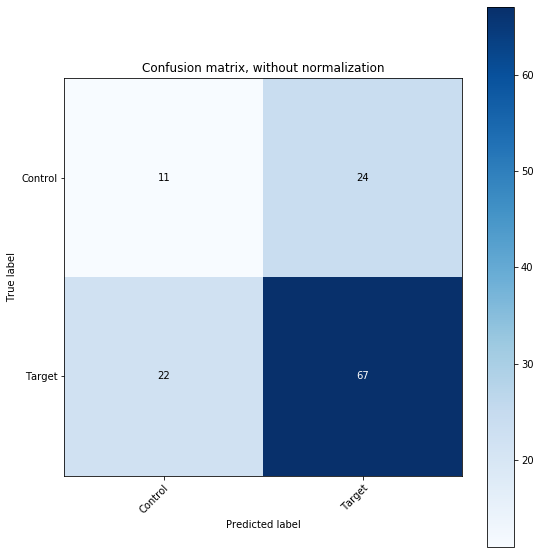

In [39]:
cm = pipeline.train_model(batch_size=20, epochs=150, cross_validation=True, parallel=False, verbose=0)

In [42]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_labels.shape

(124,)

In [43]:
orig_labels = analysis_labels.loc[reindexed_labels.index]
orig_labels["DNN Pred"] = pipeline.predictions
orig_HR = orig_labels[orig_labels["Risk"]=="HR"]

In [44]:
orig_HR.head()

,ASD_DX_group,Risk,DNN Pred
CandID,,,
916595,ASD,HR,1.0
589344,ASD,HR,1.0
973338,ASD,HR,1.0
703249,ASD,HR,1.0
526558,ASD,HR,1.0


In [52]:
_counts=[]
names=[]
for name, subgroup in orig_HR.groupby(by="ASD_DX_group"):
    names.append(name)
    _cnt = subgroup["DNN Pred"].value_counts()
    _counts.append([_cnt[0.0], _cnt[1.0]])
#     print(name, subgroup["DNN Pred"].value_counts(), sep="\n")

dnn_predictions = pd.DataFrame(_counts, columns=["Correct","Incorrect"], index=names)
dnn_predictions

,Correct,Incorrect
ASD,11,24


In [54]:
norm_pred = dnn_predictions.div(dnn_predictions.sum(axis=1), axis="index")

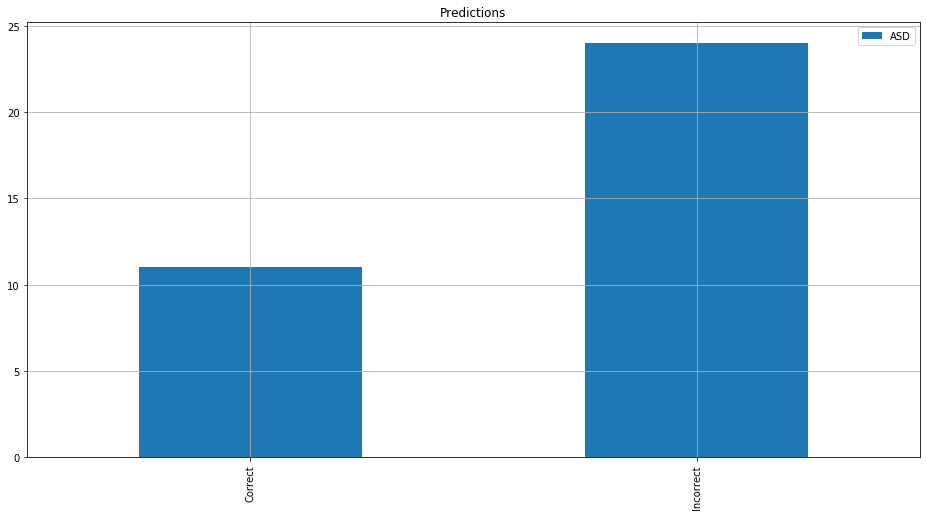

In [56]:
dnn_predictions.T.plot(kind="bar", figsize=(16,8), grid=True, title="Predictions")